In [1]:
import matplotlib.pyplot    as plt
import numpy                as np
import pandas               as pd
import plotly.express       as px
import plotly.graph_objects as go
import seaborn              as sbn
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from sklearn.preprocessing import RobustScaler
import pandas as pd


In [2]:
df = pd.read_excel('../data/Supermarket_Sales_cleaned.xlsx')
print(df.head(5))

         ID           Thời gian Thành phố     Chi nhánh Nhóm khách hàng  \
0  CUS-0007 2024-01-01 20:34:00   Đà Nẵng  ABC Hải Châu          Member   
1  CUS-0042 2024-01-18 20:04:00    TP.HCM   ABC Thủ Đức          Normal   
2  CUS-0120 2024-01-20 20:05:00    Hà Nội  ABC Cầu Giấy          Normal   
3  CUS-0080 2024-03-09 17:04:00   Đà Nẵng  ABC Hải Châu          Member   
4  CUS-0005 2024-03-30 18:03:00    TP.HCM    ABC Quận 7          Member   

  Giới tính    Phân loại  Tên SP   SKU  Giá vốn đơn vị   Giá bán  Số lượng  \
0      Male  Electronics  Laptop  1000        54130.33  70369.43         1   
1    Female  Electronics  Laptop  1000        54130.33  70369.43         3   
2      Male  Electronics  Laptop  1000        54130.33  70369.43         2   
3      Male  Electronics  Laptop  1000        54130.33  70369.43         3   
4    Female  Electronics  Laptop  1000        54130.33  70369.43         2   

        COGS  Discount Phương thức thanh toán  Doanh thu ròng  Lợi nhuận  
0   5

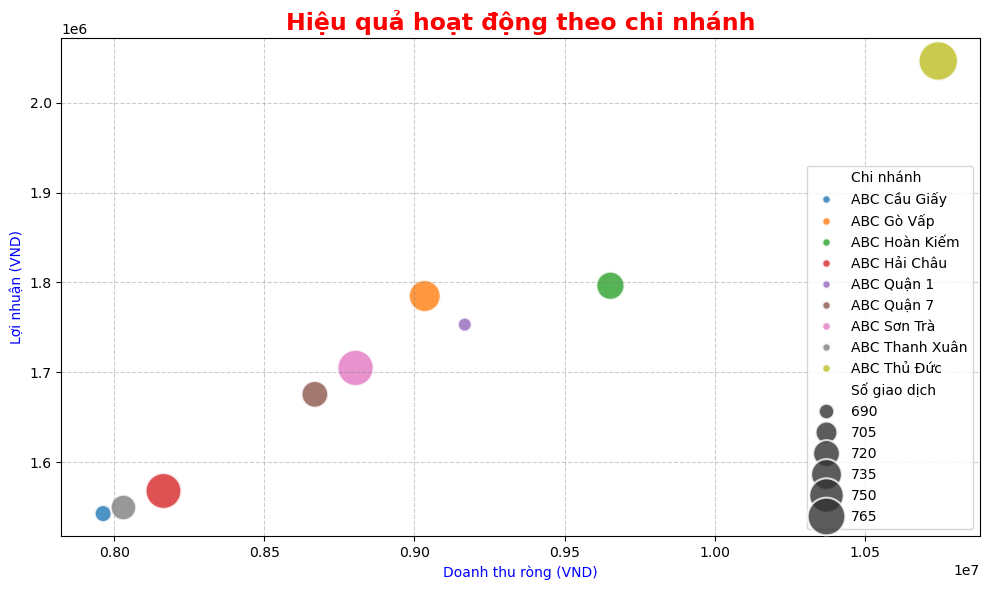

In [3]:
# hiệu quả hoạt động theo chi nhánh
df_grouped = df.groupby("Chi nhánh", as_index=False).agg({"Doanh thu ròng": "sum","Lợi nhuận": "sum","ID": "count" }).rename(columns={"ID": "Số giao dịch"})

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_grouped,
    x="Doanh thu ròng",
    y="Lợi nhuận",
    size="Số giao dịch",
    hue="Chi nhánh",
    sizes=(100, 800),
    alpha=0.8,
    marker="o", 
    edgecolor="white",
    linewidth=1.5,
    palette="tab10"
)

plt.title("Hiệu quả hoạt động theo chi nhánh",fontsize=17, weight="bold", color='r')
plt.xlabel("Doanh thu ròng (VND)", color='b')
plt.ylabel("Lợi nhuận (VND)", color='b')
plt.grid(True, linestyle="--", alpha=0.4, color='grey')
plt.tight_layout()
plt.legend(loc='lower right')
plt.show()

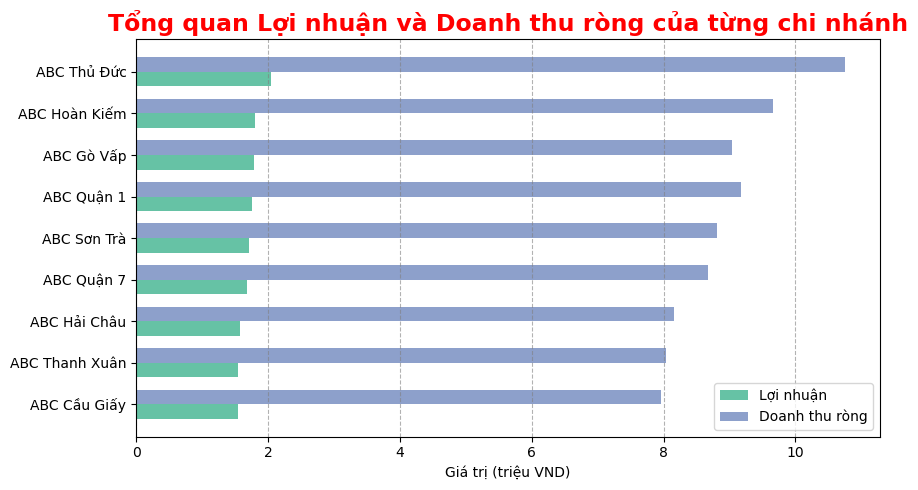

In [4]:

branch_summary = df.groupby('Chi nhánh', as_index=False).agg({
    'Lợi nhuận': 'sum',
    'Doanh thu ròng': 'sum'
})

branch_summary['Lợi nhuận (triệu)'] = branch_summary['Lợi nhuận'] / 1e6
branch_summary['Doanh thu ròng (triệu)'] = branch_summary['Doanh thu ròng'] / 1e6

branch_summary = branch_summary.sort_values(by='Lợi nhuận (triệu)', ascending=True)

y = np.arange(len(branch_summary))
bar_width = 0.35

plt.figure(figsize=(9, 5))

plt.barh(y - bar_width/2, branch_summary['Lợi nhuận (triệu)'], 
         height=bar_width, label='Lợi nhuận', color='#66c2a5')
plt.barh(y + bar_width/2, branch_summary['Doanh thu ròng (triệu)'], 
         height=bar_width, label='Doanh thu ròng', color='#8da0cb')

plt.yticks(y, branch_summary['Chi nhánh'])
plt.xlabel('Giá trị (triệu VND)')
plt.title('Tổng quan Lợi nhuận và Doanh thu ròng của từng chi nhánh', fontsize=17, weight='bold', color='r')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.6, color='grey')
plt.tight_layout()
plt.show()


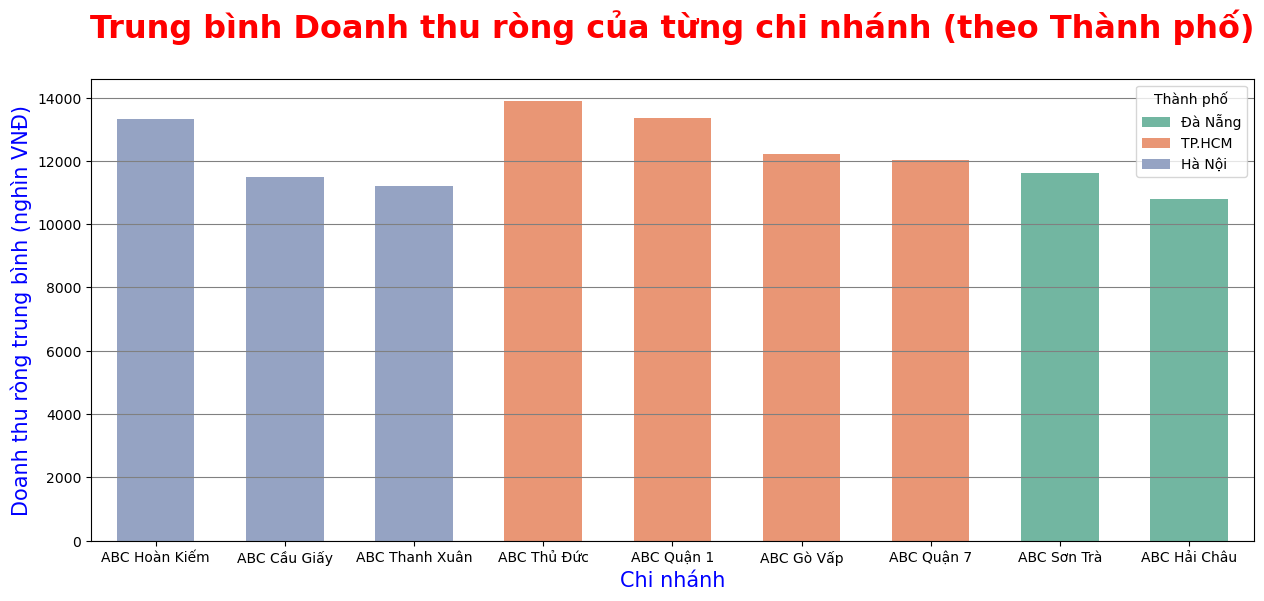

In [5]:
#doanh thu trung bình theo chi nhánh 
order = df.groupby(['Thành phố', 'Chi nhánh'])['Doanh thu ròng'].mean().reset_index()
order = order.sort_values(['Thành phố', 'Doanh thu ròng'], ascending=[True, False])['Chi nhánh']

plt.figure(figsize=(15, 6))
plt.title('Trung bình Doanh thu ròng của từng chi nhánh (theo Thành phố)', fontsize='23', color='red', y=1.07, fontweight="bold")
plt.xlabel('Chi nhánh', fontsize='15', color='blue')
plt.ylabel('Doanh thu ròng trung bình (nghìn VNĐ)', fontsize='15', color='blue')

sns.barplot(data=df, x='Chi nhánh', y='Doanh thu ròng', hue='Thành phố', estimator='mean', dodge=False, palette='Set2', errorbar=None, order=order, width=0.6)

plt.grid(axis='y', color='grey')
plt.legend(title='Thành phố')
plt.show()

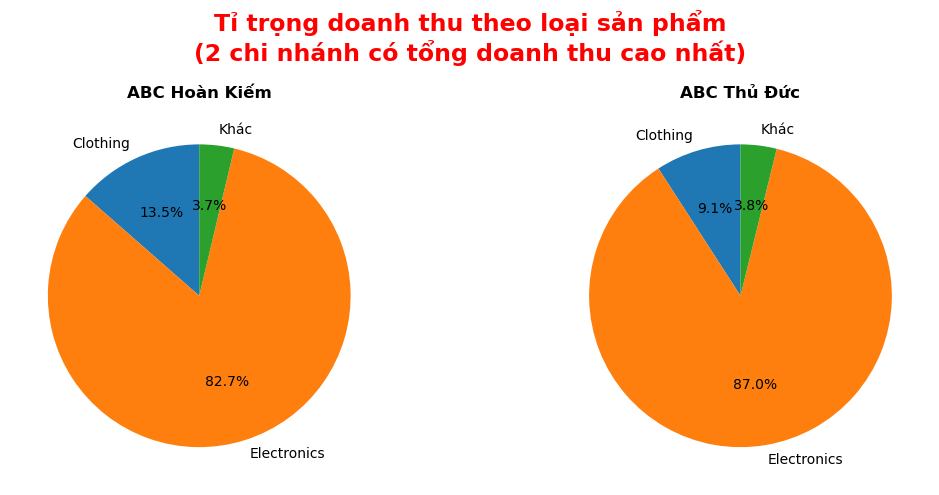

In [6]:
# tỉ lệ mỗi loại sp đóng góp vào tổng doanh thu của 2 chi nhánh có tổng doanh thu lớn nhất
branch_revenue = df.groupby("Chi nhánh")["Doanh thu ròng"].sum().sort_values(ascending=False)
top2_branches = branch_revenue.head(2).index.tolist()

top2_revenue = (df[df["Chi nhánh"].isin(top2_branches)].groupby(["Chi nhánh", "Phân loại"])["Doanh thu ròng"].sum().unstack(fill_value=0))
top2_percent = top2_revenue.div(top2_revenue.sum(axis=1), axis=0) * 100

def combine_small_categories(series, threshold=3):
    large = series[series >= threshold]
    small = series[series < threshold]
    if small.sum() > 0:
        large["Khác"] = small.sum()
    return large

combined = {branch: combine_small_categories(top2_percent.loc[branch]) for branch in top2_percent.index}

fig, axes = plt.subplots(1, 2, figsize=(11, 5))
for i, (branch, data) in enumerate(combined.items()):
    axes[i].pie(data,labels=data.index, autopct="%1.1f%%", startangle=90, colors=plt.cm.tab10.colors)
    axes[i].set_title(f"{branch}", fontsize=12, fontweight="bold")

plt.suptitle("Tỉ trọng doanh thu theo loại sản phẩm\n(2 chi nhánh có tổng doanh thu cao nhất)",color='r', fontsize=17, fontweight="bold")
plt.tight_layout()
plt.show()

#insight:
#electronics là nguồn doanh thu chủ lực chiếm trên 80% tổng doanh thu của 2 chi nhánh này
#clothing đứng thứ 2 nhưng chỉ chiếm 9-14%
#các nhóm khác chỉ chiếm phần nhỏ, ko đáng kể
# cho thấy 2 chi nhánh dẫn đầu doanh thu đều tập trung mạnh vào mảng điện tử v


<Figure size 1000x600 with 0 Axes>

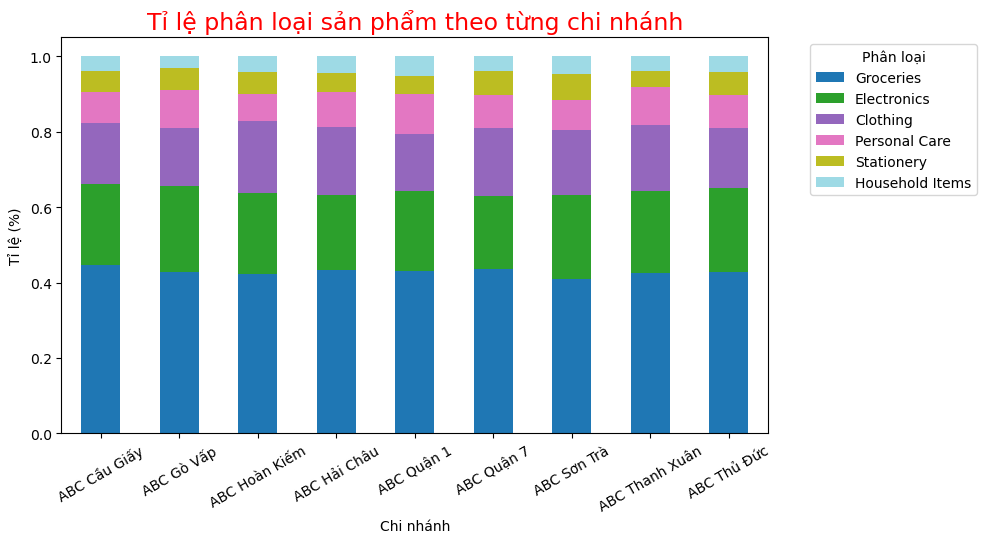

In [7]:

category_by_branch = df.groupby(["Chi nhánh", "Phân loại"]).size().unstack(fill_value=0)
category_ratio_by_branch = category_by_branch.div(category_by_branch.sum(axis=1), axis=0)

order = category_ratio_by_branch.mean().sort_values(ascending=False).index
category_ratio_by_branch = category_ratio_by_branch[order]

plt.figure(figsize=(10, 6))
category_ratio_by_branch.plot(kind="bar", stacked=True, colormap="tab20", figsize=(10, 6))

plt.title("Tỉ lệ phân loại sản phẩm theo từng chi nhánh", color='r', fontsize=17)
plt.ylabel("Tỉ lệ (%)")
plt.xlabel("Chi nhánh")
plt.legend(title="Phân loại", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.xticks(rotation=30)
plt.show()


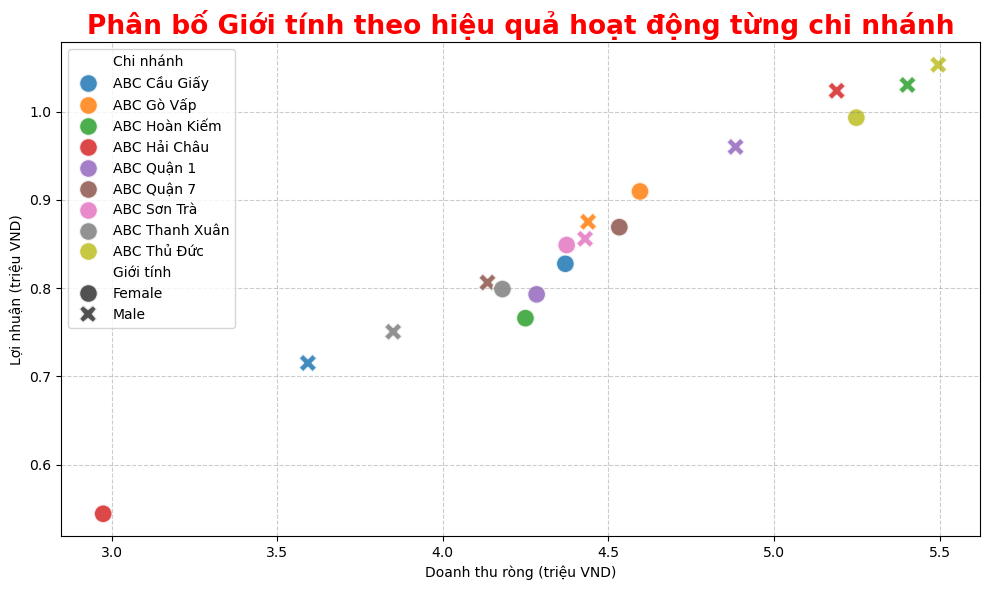

In [8]:
# Phân bố Giới tính theo hiệu quả hoạt động từng chi nhánh

df_customer = df.groupby(["Chi nhánh", "Giới tính", "ID"], as_index=False).agg({
    "Doanh thu ròng": "sum",
    "Lợi nhuận": "sum"
})

df_grouped = df_customer.groupby(["Chi nhánh", "Giới tính"], as_index=False).agg({
    "Doanh thu ròng": "sum",
    "Lợi nhuận": "sum",
    "ID": "count"
}).rename(columns={"ID": "Số khách hàng"})
df_grouped["Doanh thu ròng"] = df_grouped["Doanh thu ròng"] / 1e6
df_grouped["Lợi nhuận"] = df_grouped["Lợi nhuận"] / 1e6



plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_grouped,
    x="Doanh thu ròng",
    y="Lợi nhuận",
    hue="Chi nhánh",
    style="Giới tính",
    s=180,               
    alpha=0.85,
    marker="o",
    edgecolor="white",
    linewidth=1.5,
    palette="tab10"
)

plt.title("Phân bố Giới tính theo hiệu quả hoạt động từng chi nhánh",
          fontsize=19, weight="bold", color="red")
plt.xlabel("Doanh thu ròng (triệu VND)")
plt.ylabel("Lợi nhuận (triệu VND)")
plt.grid(True, linestyle="--", alpha=0.4, color='grey')
plt.tight_layout()
plt.show()


<Figure size 1000x500 with 0 Axes>

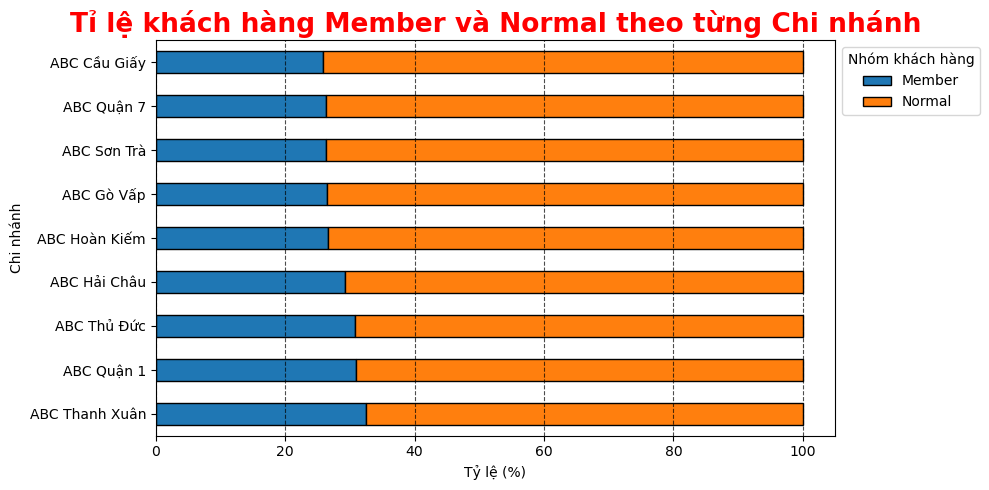

In [9]:
#nhóm khách hàng theo từng chi nhánh

cust_unique = df.groupby(["Chi nhánh", "Nhóm khách hàng"])["ID"].nunique().unstack(fill_value=0)

cust_percent = cust_unique.div(cust_unique.sum(axis=1), axis=0) * 100
cust_percent = cust_percent.sort_values(by="Member", ascending=False)

plt.figure(figsize=(10, 5))
ax = cust_percent.plot(
    kind="barh",
    stacked=True,
    color=["#1f77b4", "#ff7f0e"],
    figsize=(10, 5),
    edgecolor="black"
)

plt.title("Tỉ lệ khách hàng Member và Normal theo từng Chi nhánh",
          fontsize=19, fontweight="bold", color="r")
plt.xlabel("Tỷ lệ (%)")
plt.ylabel("Chi nhánh")
plt.legend(title="Nhóm khách hàng", loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(axis="x", linestyle="--", alpha=0.7, color="black")
plt.tight_layout()
plt.show()

#insight:
# chi nhánh có tỉ lệ member cao cho thấy khả năng giữ chân khách hàng tốt
#đó là chi nhánh ACB thanh xuân


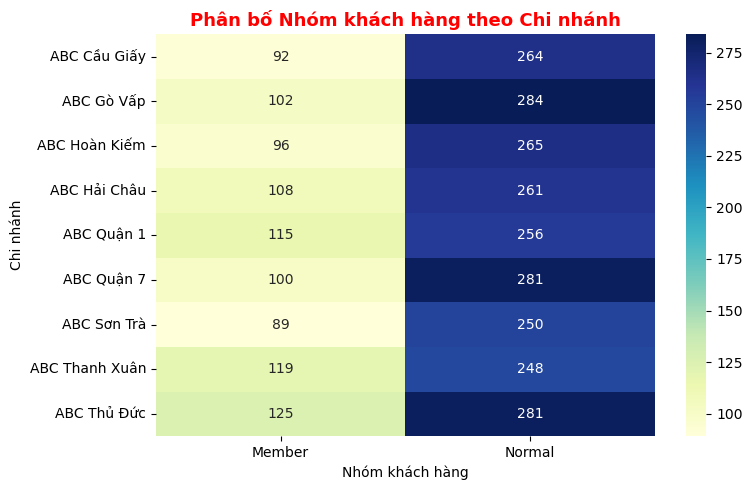

In [10]:

unique_counts = (
    df.groupby(["Chi nhánh", "Nhóm khách hàng"])["ID"]
    .nunique()
    .unstack(fill_value=0)
)

plt.figure(figsize=(8, 5))
sns.heatmap(unique_counts, annot=True, fmt='d', cmap="YlGnBu")

plt.title("Phân bố Nhóm khách hàng theo Chi nhánh", fontsize=13, weight='bold', color='r')
plt.ylabel("Chi nhánh")
plt.xlabel("Nhóm khách hàng")
plt.tight_layout()
plt.show()



<Figure size 1600x600 with 0 Axes>

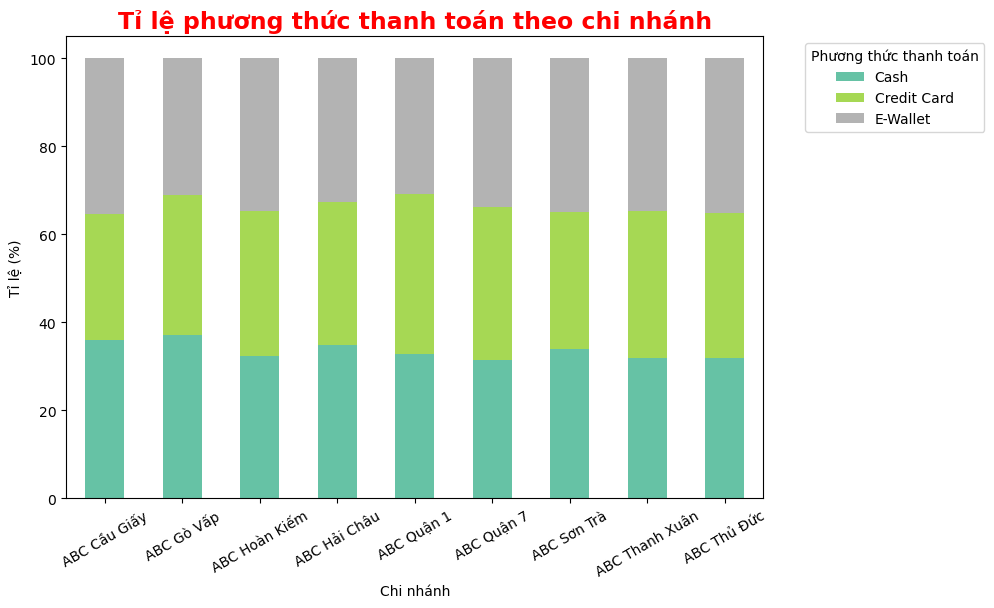

In [11]:
#phương thức thanh toán
payment_counts = df.groupby(['Chi nhánh', 'Phương thức thanh toán']).size().unstack(fill_value=0)

payment_ratio = payment_counts.div(payment_counts.sum(axis=1), axis=0) * 100

plt.figure(figsize=(16,6))
payment_ratio.plot(kind='bar', stacked=True, figsize=(9,6), colormap='Set2')

plt.title("Tỉ lệ phương thức thanh toán theo chi nhánh", fontsize=17, weight='bold', color='red')
plt.xlabel("Chi nhánh")
plt.ylabel("Tỉ lệ (%)")
plt.legend(title="Phương thức thanh toán", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=30)
plt.show()


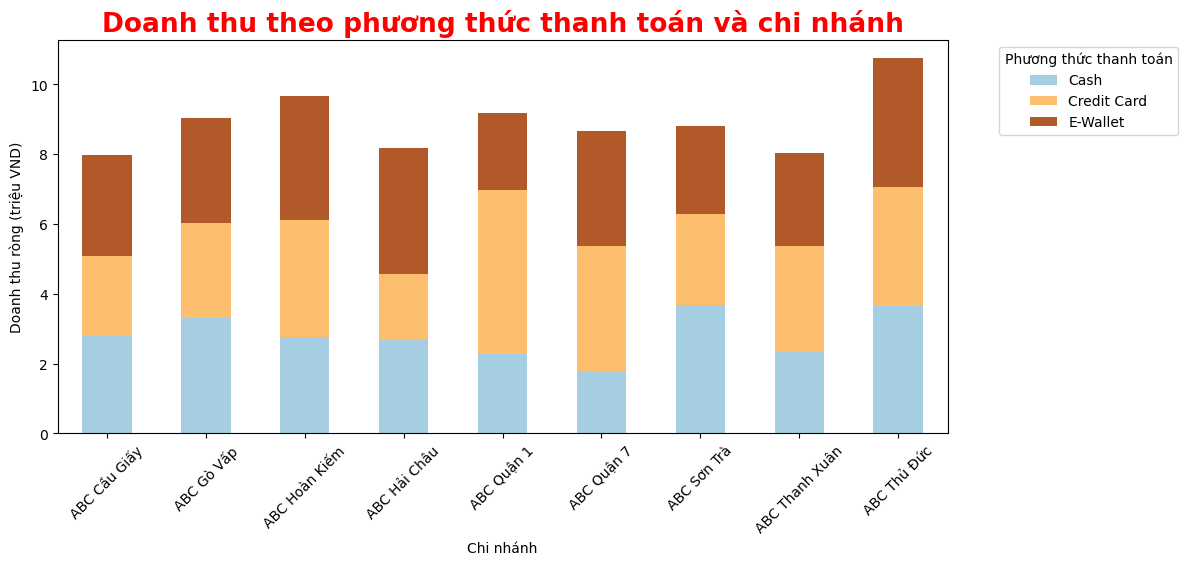

In [12]:

payment_sales = df.groupby(['Chi nhánh', 'Phương thức thanh toán'])['Doanh thu ròng'].sum().unstack(fill_value=0)
payment_sales = payment_sales / 1e6
payment_sales.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Paired')

plt.title("Doanh thu theo phương thức thanh toán và chi nhánh", fontsize=19, weight='bold', color='r')
plt.xlabel("Chi nhánh")
plt.ylabel("Doanh thu ròng (triệu VND)")
plt.legend(title="Phương thức thanh toán", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

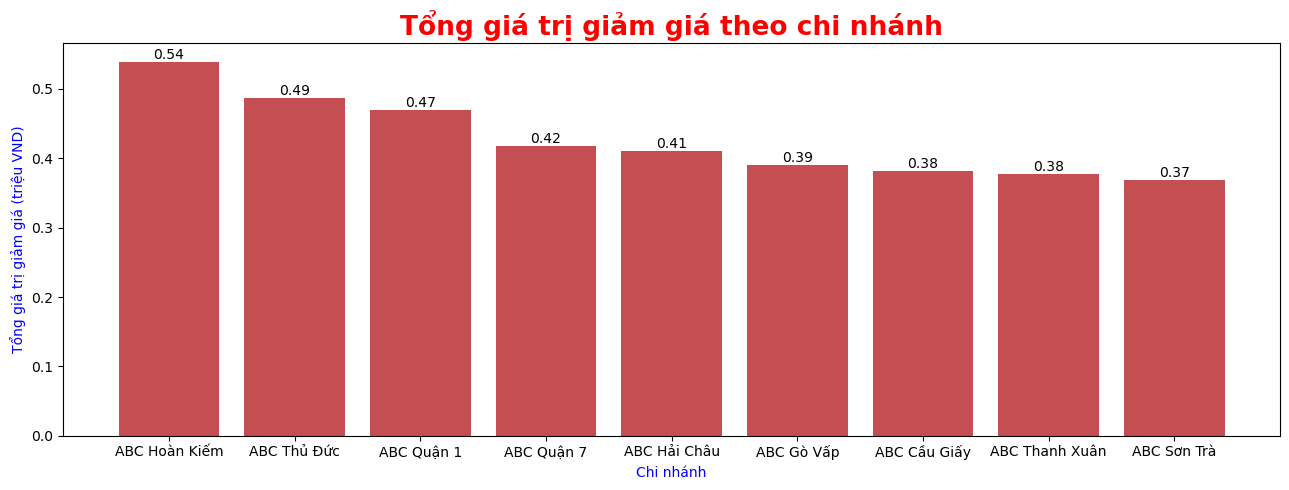

In [13]:

# tổng discount theo từng chi nhánh
# Tính tổng giá trị giảm giá theo chi nhánh (đơn vị: triệu VND)
discount_summary = df.groupby('Chi nhánh')['Discount'].sum().sort_values(ascending=False) / 1e6

plt.figure(figsize=(13,5))
bars = plt.bar(discount_summary.index, discount_summary.values, color='#C44E52')

plt.title("Tổng giá trị giảm giá theo chi nhánh", fontsize=19, weight='bold', color='r')
plt.xlabel("Chi nhánh", color='b')
plt.ylabel("Tổng giá trị giảm giá (triệu VND)", color='b')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:,.2f}", 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

#insight:
#chi nhánh có tổng discount cao nhất có thể đang áp dụng nhiều chương trình khuyến mãi hoặc xả hàng tồn kho
#ABC hoàn kiếm và thủ đức là 2 chi nhánh có tổng discount cao nhất, đồng thời cũng là 2 chi nhánh dẫn đầu trong tổng doanh thu, discount có đem lại hiệu quả


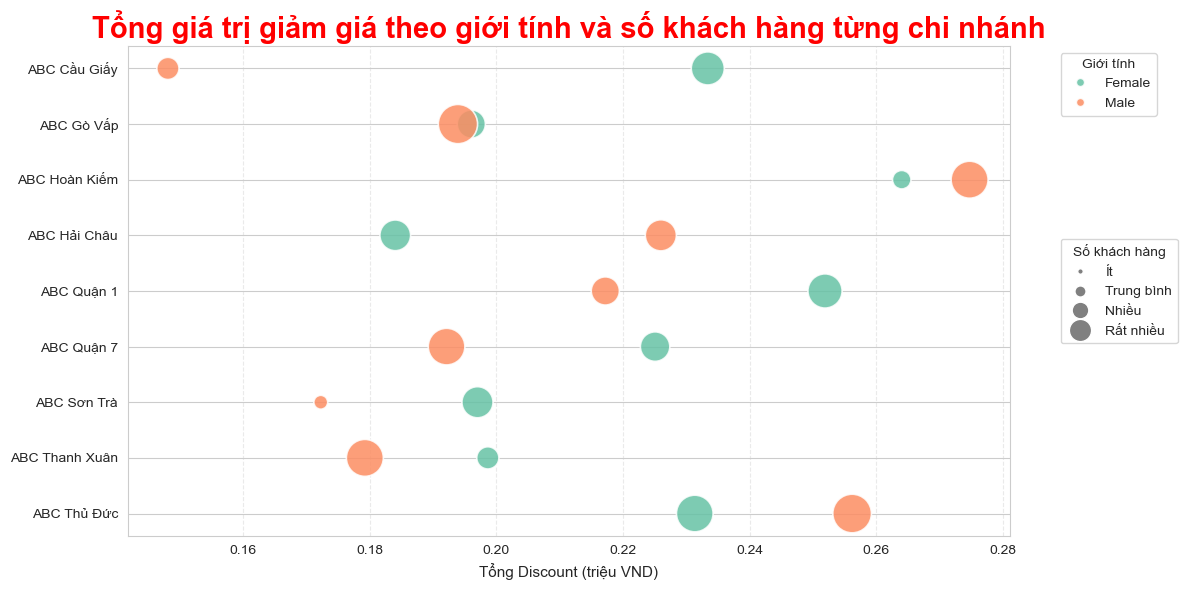

In [14]:

df_customer = df.groupby(["Chi nhánh", "Giới tính", "ID"], as_index=False)["Discount"].sum()
df_grouped = df_customer.groupby(["Chi nhánh", "Giới tính"], as_index=False).agg({
    "Discount": "sum",
    "ID": "count"
}).rename(columns={"ID": "Số khách hàng"})
df_grouped["Discount (triệu)"] = df_grouped["Discount"] / 1e6
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

ax = sns.scatterplot(
    data=df_grouped,
    x="Discount (triệu)",
    y="Chi nhánh",
    hue="Giới tính",
    size="Số khách hàng",
    sizes=(100, 800),
    alpha=0.85,
    palette="Set2",
    edgecolor="white",
    linewidth=1.2
)

handles1, labels1 = ax.get_legend_handles_labels()
gender_handles = handles1[1:len(df_grouped["Giới tính"].unique())+1]
gender_labels = labels1[1:len(df_grouped["Giới tính"].unique())+1]

legend1 = plt.legend(
    gender_handles, gender_labels,
    title="Giới tính",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    frameon=True
)

from matplotlib.lines import Line2D
size_legend = [
    Line2D([], [], marker='o', color='w', markerfacecolor='gray', 
           markersize=s/50, label=l)
    for s, l in zip([200, 400, 600, 800], ["Ít", "Trung bình", "Nhiều", "Rất nhiều"])
]

legend2 = plt.legend(
    handles=size_legend,
    title="Số khách hàng",
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
    frameon=True
)
plt.gca().add_artist(legend1) 


plt.title("Tổng giá trị giảm giá theo giới tính và số khách hàng từng chi nhánh",
          fontsize=21, weight="bold", color="red")
plt.xlabel("Tổng Discount (triệu VND)", fontsize=11)
plt.ylabel("")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
